In [2]:
import os, gc, torch
torch.cuda.empty_cache()
gc.collect()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Delete previous model/optimizer objects (if any)
try:
    del model_0, optimizer, loss_fn
except Exception as e:
    pass
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
import gdown
import zipfile
from pathlib import Path

data_dir = "data"
dataset_name = "dfdc_dataset.zip"
data_path = Path(data_dir)
dataset_folder_path = data_path / dataset_name.replace(".zip", "")

file_id = "1Et7XT-tE17HcRGzn94ujkO-x1ADxPrRJ"

if dataset_folder_path.is_dir():
    print(f"{dataset_folder_path} directory already exists.")
else:
    print(f"Did not find {dataset_folder_path} directory, creating one...")
    dataset_folder_path.mkdir(parents=True, exist_ok=True)

    zip_path = data_path / dataset_name
    print(f"Downloading {dataset_name} dataset from Google Drive...")
    gdown.download(f'https://drive.google.com/uc?id={file_id}', str(zip_path), quiet=False)

    print(f"Unzipping {dataset_name}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_path)

    print(f"Dataset {dataset_name} downloaded and extracted successfully.")

print(f"PyTorch version: {torch.__version__}")

data/dfdc_dataset directory already exists.
PyTorch version: 2.2.1+cu121


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

Using device: cuda


In [ ]:
from pathlib import Path
import os

DATASET_FOLDER = Path("data/dfdc_dataset")  

REAL_VIDEOS = DATASET_FOLDER / "real"
FAKE_VIDEOS = DATASET_FOLDER / "fake"

real_videos_list = os.listdir(REAL_VIDEOS)
fake_videos_list = os.listdir(FAKE_VIDEOS)

print(f"Number of REAL videos: {len(real_videos_list)}")
print(f"Number of FAKE videos: {len(fake_videos_list)}")

def get_video_paths_and_labels(real_videos, fake_videos):
    real_paths = [os.path.join(REAL_VIDEOS, video) for video in real_videos]
    fake_paths = [os.path.join(FAKE_VIDEOS, video) for video in fake_videos]
    video_paths = real_paths + fake_paths
    labels = [0] * len(real_paths) + [1] * len(fake_paths)  #{0 for REAL, 1 for FAKE}
    return video_paths, labels

video_paths, video_labels = get_video_paths_and_labels(real_videos_list, fake_videos_list)
print(f"Total videos: {len(video_paths)}, Total labels: {len(video_labels)}")

Number of REAL videos: 643
Number of FAKE videos: 811
Total videos: 1454, Total labels: 1454


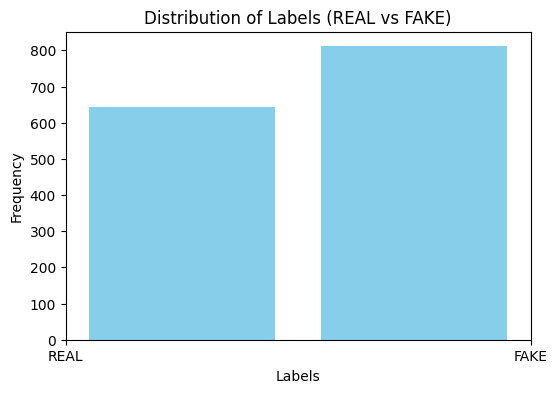

In [6]:
import matplotlib.pyplot as plt

def visualize_data_distribution(labels):
    plt.figure(figsize=(6, 4))
    plt.hist(labels, bins=2, rwidth=0.8, color="skyblue")
    plt.xticks([0, 1], ["REAL", "FAKE"])
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Distribution of Labels (REAL vs FAKE)')
    plt.show()

visualize_data_distribution(video_labels)

In [7]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    video_paths, video_labels, test_size=0.2, stratify=video_labels, random_state=42
)
print(f"Training samples: {len(train_paths)}, Testing samples: {len(test_paths)}")

Training samples: 1163, Testing samples: 291


In [ ]:
import cv2
import torch
from torchvision import transforms

IMG_SIZE = 224
MAX_NUM_FRAMES = 60

transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_video(path, max_frames=MAX_NUM_FRAMES, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(f"Tensor Frames: {total_frames}")
    frames = []
    
    if total_frames > 0:
        if total_frames >= max_frames:
            indices = [int(i * total_frames / max_frames) for i in range(max_frames)]
        else:
            indices = list(range(total_frames))
        
        frame_id = 0
        current_sample = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_id == indices[current_sample]:
                frame = cv2.resize(frame, resize)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_tensor = transform(frame)
                frames.append(frame_tensor)
                current_sample += 1
                if current_sample >= len(indices):
                    break
            frame_id += 1
    cap.release()
    
    if len(frames) < max_frames:
        if frames:
            pad_frames = [torch.zeros_like(frames[0])] * (max_frames - len(frames))
        else:
            pad_frames = [torch.zeros(3, IMG_SIZE, IMG_SIZE)] * max_frames
        frames.extend(pad_frames)

    return torch.stack(frames)

sample_video_path = train_paths[0]
video_tensor = load_video(sample_video_path)
print(f"Video tensor shape: {video_tensor.shape}")

Video tensor shape: torch.Size([60, 3, 224, 224])


In [11]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, video_paths, labels):
        self.video_paths = video_paths
        self.labels = labels

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        video_tensor = load_video(video_path)
        return video_tensor, label

train_dataset = VideoDataset(train_paths, train_labels)
test_dataset = VideoDataset(test_paths, test_labels)
print(f"Training dataset: {len(train_dataset)}, Testing dataset: {len(test_dataset)}")

Training dataset: 1163, Testing dataset: 291


In [12]:
BATCH_SIZE = 8
NUM_WORKERS = min(4, os.cpu_count() if os.cpu_count() is not None else 1)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of testing batches: {len(test_dataloader)}")

video_batch, label_batch = next(iter(train_dataloader))
print(f"Video batch shape: {video_batch.shape}, Label batch shape: {label_batch.shape}")

Number of training batches: 146
Number of testing batches: 37
Video batch shape: torch.Size([8, 60, 3, 224, 224]), Label batch shape: torch.Size([8])


In [13]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

class DeepFakeDetector(nn.Module):
    def __init__(self, hidden_size=2048, num_layers=1, dropout=0.4):
        super().__init__()
        
        weights = ResNeXt50_32X4D_Weights.DEFAULT
        resnext = resnext50_32x4d(weights=weights)

        self.cnn = nn.Sequential(
            *list(resnext.children())[:-2],
            nn.AdaptiveAvgPool2d((1, 1))      
        )

        self.cnn_fc = nn.Linear(2048, hidden_size)
        self.lstm = nn.LSTM(input_size=hidden_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, video_tensor):
        batch_size, seq_len, c, h, w = video_tensor.shape
        video_features = []

        for t in range(seq_len):
            frame = video_tensor[:, t]  
            cnn_out = self.cnn(frame).view(batch_size, -1)
            video_features.append(self.cnn_fc(cnn_out))

        video_features = torch.stack(video_features, dim=1)  
        lstm_out, _ = self.lstm(video_features)
        lstm_out = self.dropout(lstm_out)
        final_output = lstm_out[:, -1, :]
        out = self.fc(final_output)
        return out

In [14]:
import sys
try:
    model_0 = DeepFakeDetector(hidden_size=2048, num_layers=1, dropout=0.4).to(device)
except RuntimeError as e:
    print("CUDA OOM error encountered during model instantiation. Switching model to CPU.")
    model_0 = DeepFakeDetector(hidden_size=2048, num_layers=1, dropout=0.4).to("cpu")
    device = "cpu"

model_0

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/zeus/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 171MB/s]


DeepFakeDetector(
  (base_cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [15]:
video_batch, label_batch = next(iter(train_dataloader))

print(f"Video batch shape -> [batch_size, num_frames, 3, height, width]: {video_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

Video batch shape -> [batch_size, num_frames, 3, height, width]: torch.Size([8, 60, 3, 224, 224])
Label batch shape: torch.Size([8])


In [16]:
#Model needs Input like this: [batch_size, num_frames, 3, height, width]
#choose single video(sequence of frames) and unsqueeze(add batch dimension)

video_single, label_single = video_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single video shape (with batch dim): {video_single.shape}")
print(f"Single label: {label_single}")

Single video shape (with batch dim): torch.Size([1, 60, 3, 224, 224])
Single label: 1


In [17]:
model_0.eval()

with torch.no_grad():
    pred = model_0(video_single.to(device))

#raw logits -> pred_prob
pred_prob = torch.sigmoid(pred)

#pred_prob -> pred_label (0 or 1)
pred_label = (pred_prob > 0.5).float()

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{pred_prob}\n")
print(f"Output prediction label (FAKE=1, REAL=0):\n{pred_label.item()}\n")
print(f"Actual label (FAKE=1, REAL=0):\n{label_single.item()}")

Output logits:
tensor([[0.0448]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5112]], device='cuda:0')

Output prediction label (FAKE=1, REAL=0):
1.0

Actual label (FAKE=1, REAL=0):
1


In [18]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, num_frames, 3, height, width]
summary(model_0, input_size=[1, 60, 3, 224, 224])

Layer (type:depth-idx)                        Output Shape              Param #
DeepFakeDetector                              [1, 1]                    --
├─Sequential: 1-1                             [1, 2048, 7, 7]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          63,488
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          71,168
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          71,168
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          349,184

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    cur_loss = 0.0
    all_preds = []
    all_labels = []
    scaler = torch.cuda.amp.GradScaler()
    for video_tensors, labels in dataloader:
        video_tensors, labels = video_tensors.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(video_tensors).squeeze()
            loss = loss_fn(outputs, labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        cur_loss += loss.item() * video_tensors.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    train_loss = cur_loss / len(dataloader.dataset)
    accuracy = (all_preds == all_labels).sum().item() / len(all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return train_loss, accuracy, precision, recall, f1, conf_matrix

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()
    cur_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for video_tensors, labels in dataloader:
            video_tensors, labels = video_tensors.to(device), labels.to(device)
            outputs = model(video_tensors).squeeze()
            loss = loss_fn(outputs, labels.float())
            cur_loss += loss.item() * video_tensors.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    test_loss = cur_loss / len(dataloader.dataset)
    accuracy = (all_preds == all_labels).sum().item() / len(all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return test_loss, accuracy, precision, recall, f1, conf_matrix

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          epochs: int = 5):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "test_precision": [],
        "test_recall": [],
        "test_f1": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_precision, train_recall, train_f1, train_conf_matrix = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_acc, test_precision, test_recall, test_f1, test_conf_matrix = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        print(
            f"Epoch: {epoch + 1} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f} | Train F1: {train_f1:.4f} | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | "
            f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}"
        )
        print(f"Train Confusion Matrix:\n{train_conf_matrix}")
        print(f"Test Confusion Matrix:\n{test_conf_matrix}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)
    return results

In [20]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_0.parameters(),
                       lr=1e-5,
                       weight_decay=1e-6)

In [21]:
NUM_EPOCHS = 20

from timeit import default_timer as timer

start = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device,
                        epochs=NUM_EPOCHS)

model_0_results

end = timer()

print(f"Time taken to train model_0: {end-start: .3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.3033 | Train Acc: 0.8882 | Train Precision: 0.8599 | Train Recall: 0.9553 | Train F1: 0.9051 | Test Loss: 0.6231 | Test Acc: 0.7698 | Test Precision: 0.9279 | Test Recall: 0.6358 | Test F1: 0.7546
Train Confusion Matrix:
[[413 101]
 [ 29 620]]
Test Confusion Matrix:
[[121   8]
 [ 59 103]]
Epoch: 2 | Train Loss: 0.2139 | Train Acc: 0.9321 | Train Precision: 0.8992 | Train Recall: 0.9892 | Train F1: 0.9420 | Test Loss: 0.1906 | Test Acc: 0.9450 | Test Precision: 0.9148 | Test Recall: 0.9938 | Test F1: 0.9527
Train Confusion Matrix:
[[442  72]
 [  7 642]]
Test Confusion Matrix:
[[114  15]
 [  1 161]]
Epoch: 3 | Train Loss: 0.2191 | Train Acc: 0.9252 | Train Precision: 0.8947 | Train Recall: 0.9815 | Train F1: 0.9361 | Test Loss: 0.1968 | Test Acc: 0.9450 | Test Precision: 0.9148 | Test Recall: 0.9938 | Test F1: 0.9527
Train Confusion Matrix:
[[439  75]
 [ 12 637]]
Test Confusion Matrix:
[[114  15]
 [  1 161]]
Epoch: 4 | Train Loss: 0.1944 | Train Acc: 0.9355 | Tra

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

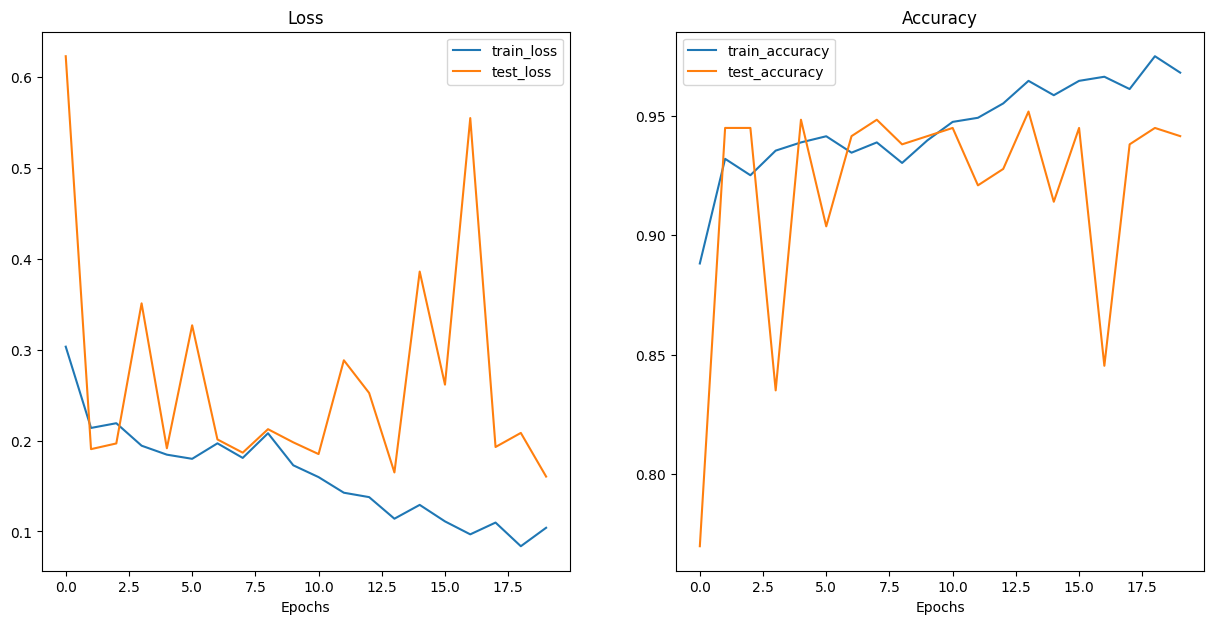

In [23]:
plot_loss_curves(model_0_results)